### Overview

We have many high-quality global climate datasets that has historic data on various climatic variables. Using cloud-hosted datasets and XArray, we can compute pixel-wise long-term trends. This analysis helps us identify hotspots experienceing extreme climate change.

We will be using the [TerraClimate](https://www.climatologylab.org/terraclimate.html) gridded dataset of monthly climate and climatic water balance at high spatial resolution (~4km grid size) with a long time-series. (1958-current). This is a large dataset that is hosted on a [THREDDS Data Server (TDS)](https://www.unidata.ucar.edu/software/tds/) and served using the [OPeNDAP](https://www.opendap.org/) (Open Data Access Protocol) protocol. XArray has built-in support to efficiently read and process OPeNDAP data where we can stream and process only the required pixels without downloading entire dataset.

This notebook shows how to extract a time-series of monthly maximum temperatures and compute per-pixel linear trend. The results are processed in a distributed matter using Dask and the results are saved as a GeoTIFF file.


### Setup and Data Download



In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install geopandas rioxarray cartopy dask[distributed] netCDF4

In [2]:
import cartopy
import cartopy.crs as ccrs
import os
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import dask

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

### Selecting a Region of Interest

[GeoBondaries](https://www.geoboundaries.org/) is an open databse of political administrative boundaries at different administrative levels. We download the Admin1 Boundaries.

In [16]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print(f'Downloaded {filename}')
    else:
        print(f'File {filename} exists.')

admin_boundaries = 'geoBoundariesCGAZ_ADM1.gpkg'

geoboundaries_url = 'https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/'
download(geoboundaries_url + admin_boundaries)


Downloaded data/geoBoundariesCGAZ_ADM1.gpkg


In [17]:
admin_boundaries_filepath = os.path.join(data_folder, admin_boundaries)
admin_gdf = gpd.read_file(admin_boundaries_filepath, encoding='utf-8')

Select the country by its [3-letter ISO code](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3). Here we use the code GHA for Ghana.

In [ ]:
country = 'GHA'
country_gdf = admin_gdf[admin_gdf['shapeGroup'] == country]
country_gdf

Select a region. We select the *Greater Accra Region*.

In [19]:
region_gdf = country_gdf[country_gdf['shapeName'] == 'Greater Accra Region']
region_gdf

,id,shapeName,shapeID,shapeGroup,shapeType,geometry
1071,None,Greater Accra Region,69750345B46963341226980,GHA,ADM1,"POLYGON ((-0.49887 5.7249, -0.48728 5.7524, -0..."


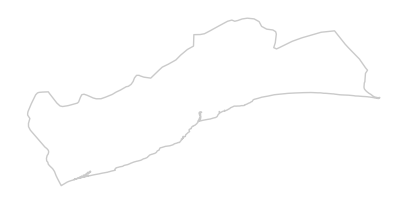

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
region_gdf.plot(
    ax=ax,
    edgecolor='#969696',
    facecolor='none',
    alpha=0.5)
ax.set_axis_off()
plt.show()

Get the bounding box to filter the XArray dataset.

In [49]:
bounds = region_gdf.total_bounds
lon_min, lat_min, lon_max, lat_max = bounds

### Local Compute Cluster

Setup a Local Dask Cluster.

In [22]:
from dask.distributed import Client, progress
client = Client()  # set up local cluster on the machine
client

/usr/local/lib/python3.11/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32897 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:40799
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:32897/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40461'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35313'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:40977 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:40977
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:38588
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:43853 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43853
IN

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:32897/status,
Dashboard: http://127.0.0.1:32897/status,Workers: 2
Total threads: 2,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40799,Workers: 2
Dashboard: http://127.0.0.1:32897/status,Total threads: 2
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:43853,Total threads: 1
Dashboard: http://127.0.0.1:35825/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:40461,


## Analysis

### Calculate Yearly Time-Series

We want to analyze the long-term yearly trend of monthly maximum temperatures.
Since the input data comes as monthly values, we first aggregate the data to yearly time steps.

In [24]:
terraclimate_url = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/'
variable = 'tmax'
filename = f'agg_terraclimate_{variable}_1958_CurrentYear_GLOBE.nc'

remote_file_path = os.path.join(terraclimate_url, filename)
ds = xr.open_dataset(
    remote_file_path,
    chunks='auto',
    engine='netcdf4',
)
ds

<xarray.Dataset> Size: 240GB
Dimensions:  (crs: 1, lon: 8640, lat: 4320, time: 804)
Coordinates:
  * crs      (crs) int16 2B 3
  * lon      (lon) float64 69kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * lat      (lat) float64 35kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * time     (time) datetime64[ns] 6kB 1958-01-01 1958-02-01 ... 2024-12-01
Data variables:
    tmax     (time, lat, lon) float64 240GB dask.array<chunksize=(66, 355, 714), meta=np.ndarray>
Attributes: (12/49)
    method:                          These layers from TerraClimate were crea...
    title:                           TerraClimate: monthly climate and climat...
    summary:                         This archive contains a dataset of high-...
    keywords:                        WORLDCLIM,global,monthly, temperature,pr...
    id:                              Blank
    naming_authority:                edu.uidaho.nkn
    ...                              ...
    geospatial_vertical_resolution:  0.0
    geospatial_vertical_positive:    Up
    references:                      Abatzoglou, J.T., S.Z. Dobrowski, S.A. P...
    source:                          WorldClim v2.0 (2.5m), CRU Ts4.0, JRA-55
    version:                         v1.0
    Conventions:                     CF-1.6

In [50]:
# Select the variable
da = ds.tmax

# Select data within the bounding box

# Make sure the data is sorted for slice() to work correctly
da = da.sortby([da.lon, da.lat])

# Add 0.1 degree buffer
da_subset = da.sel(
    lon=slice(lon_min - 0.1, lon_max + 0.1),
    lat=slice(lat_min - 0.1, lat_max + 0.1)
)
da_subset

<xarray.DataArray 'tmax' (time: 804, lat: 18, lon: 32)> Size: 4MB
dask.array<getitem, shape=(804, 18, 32), dtype=float64, chunksize=(66, 18, 32), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 256B -0.5625 -0.5208 -0.4792 ... 0.6458 0.6875 0.7292
  * lat      (lat) float64 144B 5.396 5.438 5.479 5.521 ... 6.021 6.063 6.104
  * time     (time) datetime64[ns] 6kB 1958-01-01 1958-02-01 ... 2024-12-01
Attributes:
    units:              degC
    description:        Maximum 2-m Temperature
    long_name:          air_temperature
    standard_name:      air_temperature
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    _ChunkSizes:        [   1  720 1440]

Aggregate the data to yearly means.

In [51]:
da_yearly = da_subset.groupby('time.year').mean('time')
da_yearly

<xarray.DataArray 'tmax' (year: 67, lat: 18, lon: 32)> Size: 309kB
dask.array<stack, shape=(67, 18, 32), dtype=float64, chunksize=(1, 18, 32), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 256B -0.5625 -0.5208 -0.4792 ... 0.6458 0.6875 0.7292
  * lat      (lat) float64 144B 5.396 5.438 5.479 5.521 ... 6.021 6.063 6.104
  * year     (year) int64 536B 1958 1959 1960 1961 1962 ... 2021 2022 2023 2024
Attributes:
    units:              degC
    description:        Maximum 2-m Temperature
    long_name:          air_temperature
    standard_name:      air_temperature
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    _ChunkSizes:        [   1  720 1440]

Process and load the data into memory. This may take a few minutes. Check the Dask dashboard to see the progress

> Note: The dask dashboard is not available on Colab.

In [52]:
%%time
da_yearly = da_yearly.compute()

CPU times: user 5.77 s, sys: 866 ms, total: 6.64 s
Wall time: 1min 23s


Plot a time-series at a single location to see the trend.

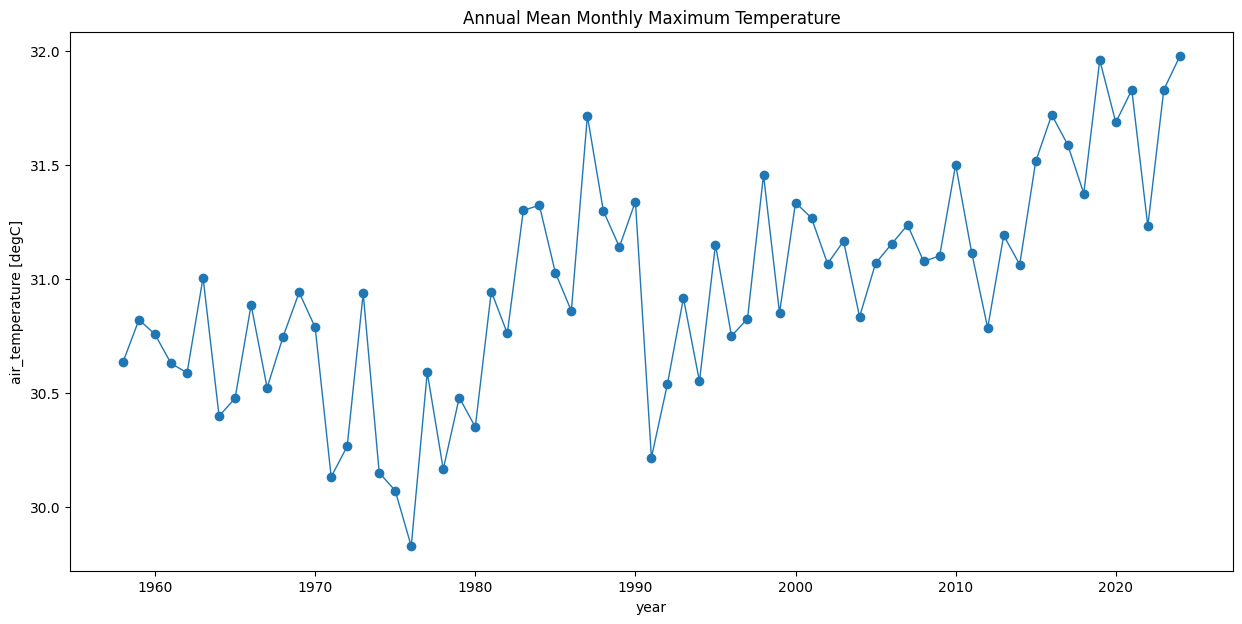

In [56]:
# Choose a location within the region for plots
location = (5.65, -0.20) # Accra

time_series = da_yearly.interp(lat=location[0], lon=location[1])

fig, ax = plt.subplots(1, 1)

fig.set_size_inches(15, 7)
time_series.plot.line(ax=ax, x='year', marker='o', linestyle='-', linewidth=1)
ax.set_title('Annual Mean Monthly Maximum Temperature')
plt.show()

### Compute the Trend

We can fit a polynomial at each pixel of the DataArray using the [`xarray.DataArray.polyfit`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.polyfit.html) method. Here we fit a linear trendline. As out input dataset has yearly time steps, the slope of the fitted trendline will be degrees per year. To make the trend more interpretable, we multiply it by 100 to get the results in the unit degrees per century.

In [57]:
trend = da_yearly.polyfit('year', 1) # fit polynomial of degree 1
slope = trend.polyfit_coefficients[0,...] * 100 # per year -> per century

Visualize the slope of trendline.

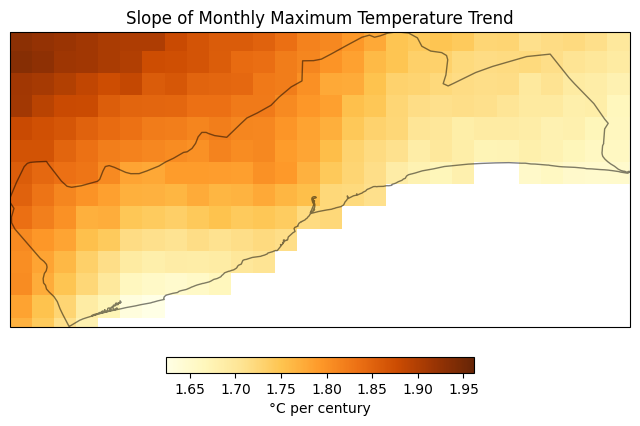

In [58]:
projection = ccrs.PlateCarree()

cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither',
    'label': '°C per century'
}

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection})
fig.set_size_inches(8, 8)
slope.plot.imshow(
    ax=ax,
    cmap='YlOrBr',
    transform=ccrs.PlateCarree(),
    add_labels=False,
    cbar_kwargs=cbar_kwargs)

region_gdf.plot(
    ax=ax,
    edgecolor='#000000',
    facecolor='none',
    alpha=0.5)

ax.set_extent((lon_min,lon_max,lat_min,lat_max), crs = ccrs.PlateCarree())

plt.title(f'Slope of Monthly Maximum Temperature Trend', fontsize = 12)
plt.show()

Save the resulting slope raster as a GeoTIFF.

In [60]:
# Assign a CRS to the DataArray
slope.rio.write_crs('EPSG:4326', inplace=True)
# Clip to the GeoDataFrame coundary
clipped = slope.rio.clip(region_gdf.geometry.values)
# Write the file
output_slope_file = f'{variable}_slope.tif'
output_slope_path = os.path.join(output_folder, output_slope_file)
if not os.path.exists(output_slope_path):
    clipped.rio.to_raster(output_slope_path)
    print('Saved the file at ', output_slope_path)

Saved the file at  output/tmax_slope.tif


We can also save the yearly aggregated subset as a NetCDF for other downstream analysis.

In [46]:
local_subset_file = f'{variable}_yearly_subset.nc'
local_subset_filepath = os.path.join(output_folder, local_subset_file)
if not os.path.exists(local_subset_filepath):
    da_yearly.to_netcdf(path=local_subset_filepath)
    print('Saved the file at ', local_subset_filepath)

Saved the file at  output/tmax_yearly_subset.nc
